In [ ]:
!unzip TrackC.zip

In [ ]:
!nvidia-smi


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.3511
Train Micro-F1: 0.3424, Macro-F1: 0.1743, Weighted-F1: 0.3199
Val Loss: 0.2724
Val Micro-F1: 0.5615, Macro-F1: 0.2362, Weighted-F1: 0.4811

Epoch 2/10


Training:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.2471
Train Micro-F1: 0.6339, Macro-F1: 0.3383, Weighted-F1: 0.5800
Val Loss: 0.2590
Val Micro-F1: 0.6270, Macro-F1: 0.3585, Weighted-F1: 0.5782

Epoch 3/10


Training:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.1824
Train Micro-F1: 0.7565, Macro-F1: 0.5137, Weighted-F1: 0.7233
Val Loss: 0.2726
Val Micro-F1: 0.6208, Macro-F1: 0.3965, Weighted-F1: 0.5903

Epoch 4/10


Training:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.1217
Train Micro-F1: 0.8518, Macro-F1: 0.6927, Weighted-F1: 0.8373
Val Loss: 0.3201
Val Micro-F1: 0.6343, Macro-F1: 0.4593, Weighted-F1: 0.6195

Epoch 5/10


Training:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0808
Train Micro-F1: 0.9036, Macro-F1: 0.8011, Weighted-F1: 0.8981
Val Loss: 0.3701
Val Micro-F1: 0.6257, Macro-F1: 0.4780, Weighted-F1: 0.6115

Epoch 6/10


Training:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0668
Train Micro-F1: 0.9148, Macro-F1: 0.8369, Weighted-F1: 0.9122
Val Loss: 0.4060
Val Micro-F1: 0.6577, Macro-F1: 0.4913, Weighted-F1: 0.6365

Epoch 7/10


Training:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0556
Train Micro-F1: 0.9329, Macro-F1: 0.8724, Weighted-F1: 0.9309
Val Loss: 0.3968
Val Micro-F1: 0.6472, Macro-F1: 0.4898, Weighted-F1: 0.6311

Epoch 8/10


Training:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0470
Train Micro-F1: 0.9498, Macro-F1: 0.9268, Weighted-F1: 0.9496
Val Loss: 0.4555
Val Micro-F1: 0.6133, Macro-F1: 0.4683, Weighted-F1: 0.6118

Epoch 9/10


Training:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0544
Train Micro-F1: 0.9354, Macro-F1: 0.8890, Weighted-F1: 0.9347
Val Loss: 0.4635
Val Micro-F1: 0.6374, Macro-F1: 0.4833, Weighted-F1: 0.6267

Epoch 10/10


Training:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0324
Train Micro-F1: 0.9627, Macro-F1: 0.9326, Weighted-F1: 0.9623
Val Loss: 0.5190
Val Micro-F1: 0.6268, Macro-F1: 0.5081, Weighted-F1: 0.6159


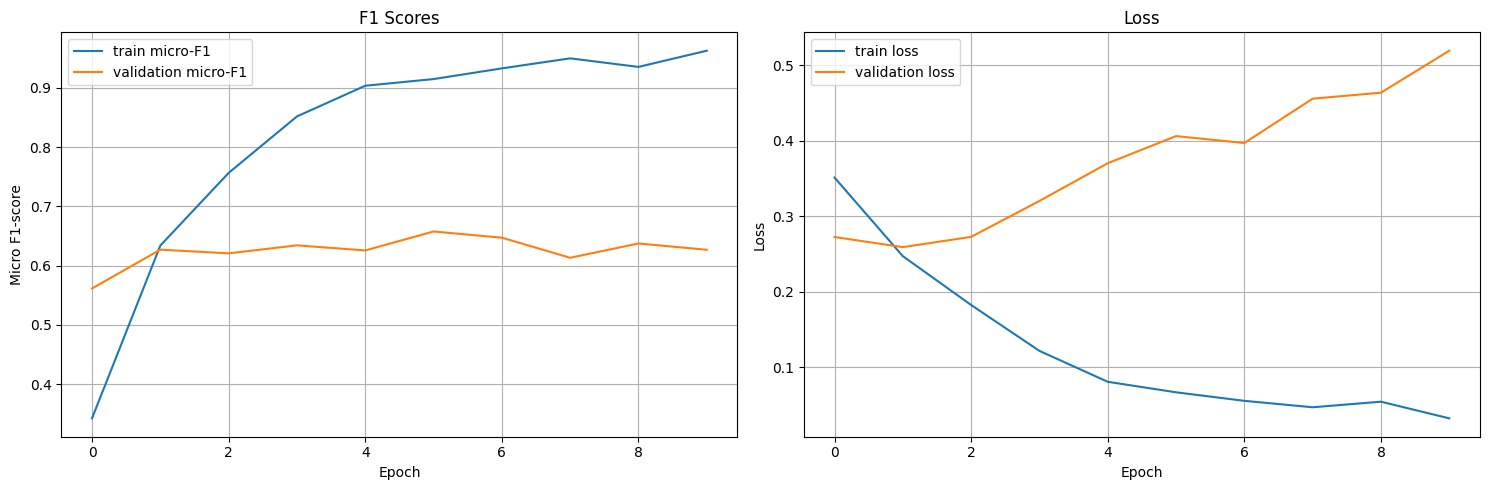

In [ ]:
import os
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

class Config:
    """Configuration class to store model and training parameters."""
    def __init__(self):
        self.MAX_LEN = 256
        self.TRAIN_BATCH_SIZE = 32
        self.VALID_BATCH_SIZE = 32
        self.TEST_BATCH_SIZE = 32
        self.EPOCHS = 10
        self.LEARNING_RATE = 1e-04
        self.THRESHOLD = 0.5
        self.MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TextDataset(Dataset):
    """Custom Dataset for text classification."""
    def __init__(self, df: pd.DataFrame, tokenizer: BertTokenizer, max_len: int, target_columns: List[str]):
        self.tokenizer = tokenizer
        self.texts = df['text'].values
        self.targets = df[target_columns].values
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, index: int) -> Dict:
        text = str(self.texts[index])
        text = " ".join(text.split())  # Clean extra whitespace

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'text': text
        }

class BERTClassifier(nn.Module):
    """BERT-based multi-label classifier."""
    def __init__(self, model_name: str, num_labels: int):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name, return_dict=True)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(1024, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = self.dropout(outputs.pooler_output)
        return self.classifier(pooled_output)

class ModelTrainer:
    """Handles model training and evaluation with F1 score metrics."""
    def __init__(self, model, config: Config):
        self.model = model
        self.config = config
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = self._get_optimizer()
        self.history = defaultdict(list)
        self.best_f1 = 0

    def _get_optimizer(self) -> AdamW:
        # Collect different parameter groups
        bert_parameters = [(name, param) for name, param in self.model.bert.named_parameters()]
        classifier_parameters = list(self.model.classifier.named_parameters())

        # Create parameter groups with different learning rates
        optimizer_parameters = [
            {
                "params": [p for n, p in bert_parameters if "encoder" in n],
                "lr": self.config.LEARNING_RATE
            },
            {
                "params": [p for n, p in bert_parameters if "embeddings" in n],
                "lr": self.config.LEARNING_RATE / 2
            },
            {
                "params": [p for n, p in classifier_parameters],
                "lr": self.config.LEARNING_RATE * 10
            }
        ]

        return AdamW(optimizer_parameters)

    def calculate_metrics(self, predictions: np.ndarray, targets: np.ndarray) -> Tuple[float, float, float]:
        """Calculate F1 scores (micro, macro, weighted)."""
        micro_f1 = f1_score(targets, predictions, average='micro')
        macro_f1 = f1_score(targets, predictions, average='macro')
        weighted_f1 = f1_score(targets, predictions, average='weighted')
        return micro_f1, macro_f1, weighted_f1

    def train_epoch(self, data_loader: DataLoader) -> Tuple[float, float, float, float]:
        """Train the model for one epoch."""
        self.model.train()
        total_loss = 0
        all_predictions = []
        all_targets = []

        progress_bar = tqdm(data_loader, desc="Training", leave=True)

        for batch in progress_bar:
            self.optimizer.zero_grad()

            input_ids = batch['input_ids'].to(self.config.DEVICE)
            attention_mask = batch['attention_mask'].to(self.config.DEVICE)
            token_type_ids = batch['token_type_ids'].to(self.config.DEVICE)
            targets = batch['targets'].to(self.config.DEVICE)

            outputs = self.model(input_ids, attention_mask, token_type_ids)
            loss = self.criterion(outputs, targets)

            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()

            # Get predictions
            predictions = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()

            all_predictions.extend(predictions)
            all_targets.extend(targets)

            progress_bar.set_postfix({'loss': loss.item()})

        # Convert lists to numpy arrays
        all_predictions = np.array(all_predictions)
        all_targets = np.array(all_targets)

        # Calculate F1 scores
        micro_f1, macro_f1, weighted_f1 = self.calculate_metrics(all_predictions, all_targets)
        avg_loss = total_loss / len(data_loader)

        return avg_loss, micro_f1, macro_f1, weighted_f1

    def evaluate(self, data_loader: DataLoader) -> Tuple[float, float, float, float]:
        """Evaluate the model."""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(self.config.DEVICE)
                attention_mask = batch['attention_mask'].to(self.config.DEVICE)
                token_type_ids = batch['token_type_ids'].to(self.config.DEVICE)
                targets = batch['targets'].to(self.config.DEVICE)

                outputs = self.model(input_ids, attention_mask, token_type_ids)
                loss = self.criterion(outputs, targets)

                total_loss += loss.item()

                predictions = torch.sigmoid(outputs).cpu().numpy().round()
                targets = targets.cpu().numpy()

                all_predictions.extend(predictions)
                all_targets.extend(targets)

        # Convert lists to numpy arrays
        all_predictions = np.array(all_predictions)
        all_targets = np.array(all_targets)

        # Calculate F1 scores
        micro_f1, macro_f1, weighted_f1 = self.calculate_metrics(all_predictions, all_targets)
        avg_loss = total_loss / len(data_loader)

        return avg_loss, micro_f1, macro_f1, weighted_f1

    def train(self, train_loader: DataLoader, val_loader: DataLoader, save_dir: str):
        """Train the model for multiple epochs."""
        for epoch in range(1, self.config.EPOCHS + 1):
            print(f'\nEpoch {epoch}/{self.config.EPOCHS}')

            train_loss, train_micro_f1, train_macro_f1, train_weighted_f1 = self.train_epoch(train_loader)
            val_loss, val_micro_f1, val_macro_f1, val_weighted_f1 = self.evaluate(val_loader)

            print(f'Train Loss: {train_loss:.4f}')
            print(f'Train Micro-F1: {train_micro_f1:.4f}, Macro-F1: {train_macro_f1:.4f}, Weighted-F1: {train_weighted_f1:.4f}')
            print(f'Val Loss: {val_loss:.4f}')
            print(f'Val Micro-F1: {val_micro_f1:.4f}, Macro-F1: {val_macro_f1:.4f}, Weighted-F1: {val_weighted_f1:.4f}')

            # Save metrics
            self.history['train_loss'].append(train_loss)
            self.history['train_micro_f1'].append(train_micro_f1)
            self.history['val_loss'].append(val_loss)
            self.history['val_micro_f1'].append(val_micro_f1)

            # Save best model based on micro F1 score
            if val_micro_f1 > self.best_f1:
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                torch.save(self.model.state_dict(),
                         os.path.join(save_dir, "best_model.bin"))
                self.best_f1 = val_micro_f1

    def plot_training_history(self):
        """Plot training and validation metrics."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot F1 scores
        ax1.plot(self.history['train_micro_f1'], label='train micro-F1')
        ax1.plot(self.history['val_micro_f1'], label='validation micro-F1')
        ax1.set_title('F1 Scores')
        ax1.set_ylabel('Micro F1-score')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True)

        # Plot losses
        ax2.plot(self.history['train_loss'], label='train loss')
        ax2.plot(self.history['val_loss'], label='validation loss')
        ax2.set_title('Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

def main():
    # Initialize configuration
    config = Config()

    # Load and preprocess data
    data = pd.read_csv('TrackC/ptbr/ptbr_train.csv')
    data.drop(columns=['id'], inplace=True)
    target_columns = [col for col in data.columns if col != 'text']

    # Split data
    train_df, temp_df = train_test_split(data, test_size=0.2, random_state=41)
    val_df = temp_df  # Using the entire temp_df as validation set

    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained(config.MODEL_NAME, do_lower_case=False)

    # Create datasets
    train_dataset = TextDataset(train_df, tokenizer, config.MAX_LEN, target_columns)
    val_dataset = TextDataset(val_df, tokenizer, config.MAX_LEN, target_columns)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config.TRAIN_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.VALID_BATCH_SIZE)

    # Initialize model
    model = BERTClassifier(config.MODEL_NAME, len(target_columns))
    model.to(config.DEVICE)

    # Initialize trainer
    trainer = ModelTrainer(model, config)

    # Train model
    trainer.train(train_loader, val_loader, save_dir="output")

    # Plot training history
    trainer.plot_training_history()

if __name__ == "__main__":
    main()